# IceCube - EDA

## Load Data

In [1]:
%cd ..

/home/jovyan/ice-cube


In [2]:
import sys

sys.path.append(".")

In [3]:
import logging

logging.basicConfig(
    # filename=__file__.replace('.py', '.log'),
    level=logging.getLevelName("INFO"),
    format="%(asctime)s [%(levelname)s] [%(module)s] %(message)s",
)

log = logging.getLogger(__name__)

In [4]:
import glob
import math
import os
import re

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scipy.stats as stats
import seaborn as sns
from omegaconf import OmegaConf
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage

# from pandas_profiling import ProfileReport

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_colwidth", None)

In [5]:
from src.ice_cube.data_loader import make_test_dataloader
from src.ice_cube.model import load_pretrained_model
from src.ice_cube.scoring import angular_dist_score
from src.load_data import LoadData
from src.preprocesses.cache import fit_instance, transform_data
from src.preprocesses.p001_dist_transformer import DistTransformer
from src.utils import choice_seed, df_stats, fix_seed

graphnet: INFO     2023-03-02 07:05:08 - get_logger - Writing log to logs/graphnet_20230302-070508.log


2023-03-02 07:05:08,133 [INFO] [logging] Writing log to logs/graphnet_20230302-070508.log


graphnet: WARNING  2023-03-02 07:05:08 - warn_once - `icecube` not available. Some functionality may be missing.


2023-03-02 07:05:08,141 [WARNING] [logging] `icecube` not available. Some functionality may be missing.
/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [6]:
# Competition specific packages
import os
import sqlite3
from typing import Any, Dict, List, Optional

import pyarrow.parquet as pq
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from graphnet.data.constants import FEATURES, TRUTH
from graphnet.data.sqlite import SQLiteDataset

# import sqlalchemy
# import graphnet
# from graphnet.data.sqlite.sqlite_utilities import create_table

In [7]:
c_main = OmegaConf.load("./config/main.yaml")
c_data = OmegaConf.load("./config/data.yaml")
c = OmegaConf.merge(c_main, c_data)

fix_seed(choice_seed(c))

2023-03-02 07:05:09,984 [INFO] [utils] Fix seed: 440


In [8]:
input = LoadData(c, use_fold=False, do_preprocess=False)

2023-03-02 07:05:09,989 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/train_meta.parquet
2023-03-02 07:05:17,566 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/test_meta.parquet
2023-03-02 07:05:17,573 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
2023-03-02 07:05:17,576 [INFO] [load_data] Load original file. path: ../input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv


In [9]:
results = pd.read_csv("results.csv")

In [10]:
submission_low_sigma = pd.read_csv("submission_low_sigma.csv")
submission_high_sigma = pd.read_csv("submission_high_sigma.csv")

In [11]:
[col for col in dir(input) if not col.startswith("__")]

['c', 'sample_submission', 'sensor_geometry', 'test_meta', 'train_meta']

## Check Data

In [11]:
input.sample_submission.shape

(3, 3)

In [12]:
input.sample_submission

,event_id,azimuth,zenith
0,2092,1,1
1,7344,1,1
2,9482,1,1


In [13]:
input.sensor_geometry.shape

(5160, 4)

In [14]:
input.sensor_geometry

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95
...,...,...,...,...
5155,5155,-10.97,6.72,-472.39
5156,5156,-10.97,6.72,-479.39
5157,5157,-10.97,6.72,-486.40
5158,5158,-10.97,6.72,-493.41


In [15]:
input.sensor_geometry.describe()

,sensor_id,x,y,z
count,5160.000000,5160.000000,5160.000000,5160.000000
mean,2579.500000,5.870829,-2.518609,-23.905766
std,1489.708025,285.151213,269.409729,296.456563
min,0.000000,-570.900000,-521.080000,-512.820000
25%,1289.750000,-224.090000,-209.070000,-283.200000
50%,2579.500000,16.990000,-6.055000,-35.115000
75%,3869.250000,224.580000,211.660000,228.557500
max,5159.000000,576.370000,509.500000,524.560000


In [16]:
input.test_meta.shape

(3, 4)

In [17]:
input.test_meta

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


In [18]:
input.train_meta.shape

(131953924, 6)

In [19]:
input.train_meta

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117
...,...,...,...,...,...,...
131953919,660,2147483597,24339210,24339349,5.895612,0.333071
131953920,660,2147483603,24339350,24339383,3.273695,1.503301
131953921,660,2147483617,24339384,24339424,2.945376,1.723253
131953922,660,2147483626,24339425,24339499,1.616582,1.937025


In [20]:
input.train_meta[input.train_meta["batch_id"] == 440]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
87800000,440,1428988469,0,68,0.043206,1.044615
87800001,440,1428988485,69,127,4.788015,1.519801
87800002,440,1428988489,128,168,6.002178,1.839276
87800003,440,1428988503,169,272,1.292094,1.340804
87800004,440,1428988518,273,2249,1.894584,2.006880
...,...,...,...,...,...,...
87999995,440,1432234735,33121697,33121749,3.702434,2.157144
87999996,440,1432234738,33121750,33121793,4.382589,1.891504
87999997,440,1432234762,33121794,33121934,3.655561,2.414422
87999998,440,1432234772,33121935,33121990,2.190492,2.276862


In [21]:
submission_high_sigma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148544 entries, 0 to 148543
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   event_id  148544 non-null  float64
 1   azimuth   148544 non-null  float64
 2   zenith    148544 non-null  float64
dtypes: float64(3)
memory usage: 3.4 MB


In [22]:
submission_high_sigma.head()

,event_id,azimuth,zenith
0,1.432235e+09,1.643871,1.595458
1,1.432235e+09,0.777158,1.973433
2,1.432235e+09,4.068247,0.610144
3,1.432235e+09,3.589098,1.522334
4,1.432235e+09,3.469211,2.925182


In [23]:
submission_high_sigma["event_id"] = submission_high_sigma["event_id"].astype(int)

In [25]:
submission_high_sigma.columns = ["event_id", "azimuth_preds", "zenith_preds"]

In [30]:
meta_high_sigma = pd.merge(
    input.train_meta[input.train_meta["batch_id"] == 441],
    submission_high_sigma,
    on="event_id",
)

In [31]:
meta_high_sigma.shape

(148544, 8)

In [32]:
meta_high_sigma.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,azimuth_preds,zenith_preds
0,441,1432234834,0,51,1.927610,2.137743,1.643871,1.595458
1,441,1432234838,52,109,0.605587,0.864771,0.777158,1.973433
2,441,1432234846,110,171,6.110872,1.286081,4.068247,0.610144
3,441,1432234917,346,411,2.362682,2.656823,3.589098,1.522334
4,441,1432234937,505,554,3.397901,2.148571,3.469211,2.925182


In [39]:
event_ids_high_sigma = meta_high_sigma["event_id"].to_numpy()

In [229]:
event_ids_high_sigma

array([1432234834, 1432234838, 1432234846, ..., 1435497101, 1435497111,
       1435497125], dtype=object)

In [131]:
meta_high_sigma[meta_high_sigma["event_id"] == 1432240503]

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,azimuth_preds,zenith_preds
269,441,1432240503,61906,62023,2.127084,0.713541,4.142732,1.233107


In [133]:
angular_dist_score(2.127084, 0.713541, 4.142732, 1.233107)

1.5860584923139365

## Read single batch

In [20]:
batch_num = 661
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_test, f"batch_{batch_num}.parquet")
).reset_index()

In [21]:
batch.shape

(378, 5)

In [22]:
batch.loc[0:298, :]

,event_id,sensor_id,time,charge,auxiliary
0,2092,4066,6170,1.275,True
1,2092,3512,6374,0.975,True
2,2092,897,6378,1.475,True
3,2092,2060,6590,0.925,True
4,2092,3072,6625,1.075,True
...,...,...,...,...,...
294,2092,4998,22868,1.125,True
295,2092,2152,24147,0.925,True
296,2092,3229,24502,0.525,True
297,2092,5156,25399,0.875,True


In [23]:
batch["charge"].describe(percentiles=[0.1, 0.9])

count    378.000000
mean       0.989947
std        0.465175
min        0.125000
10%        0.475000
50%        0.975000
90%        1.475000
max        4.775000
Name: charge, dtype: float64

In [28]:
batch_num = 441
batch = pd.read_parquet(
    os.path.join(c.data.dir.input_train, f"batch_{batch_num}.parquet")
).reset_index()

In [29]:
batch.shape

(32996025, 5)

In [30]:
batch

,event_id,sensor_id,time,charge,auxiliary
0,1432234834,1420,5893,1.575,True
1,1432234834,5143,6010,1.075,True
2,1432234834,842,6332,0.975,True
3,1432234834,541,6732,0.825,True
4,1432234834,685,6855,1.175,True
...,...,...,...,...,...
32996020,1435497129,2574,15041,0.975,True
32996021,1435497129,1041,15338,1.075,True
32996022,1435497129,620,15575,0.575,True
32996023,1435497129,620,15587,1.075,True


In [36]:
batch["event_id"].unique().shape

(200000,)

In [37]:
max(batch["charge"])

2902.925048828125

In [38]:
batch["charge"].describe(percentiles=[0.05, 0.9])

count    3.299602e+07
mean     3.998304e+00
std      1.608011e+01
min      2.500000e-02
5%       3.750000e-01
50%      1.075000e+00
90%      5.675000e+00
max      2.902925e+03
Name: charge, dtype: float64

In [31]:
batch = pd.merge(batch, input.sensor_geometry, on="sensor_id")

In [32]:
batch

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,1432234834,1420,5893,1.575,True,-245.65,-190.49,-178.97
1,1432235925,1420,10697,0.975,False,-245.65,-190.49,-178.97
2,1432235925,1420,10714,0.325,False,-245.65,-190.49,-178.97
3,1432240503,1420,10995,0.525,False,-245.65,-190.49,-178.97
4,1432240503,1420,11980,0.925,False,-245.65,-190.49,-178.97
...,...,...,...,...,...,...,...,...
32996020,1435489061,1957,12546,0.675,False,-324.39,-93.43,-129.63
32996021,1435490661,1957,8859,0.775,True,-324.39,-93.43,-129.63
32996022,1435491737,1957,10671,1.375,False,-324.39,-93.43,-129.63
32996023,1435491737,1957,10712,1.125,False,-324.39,-93.43,-129.63


In [41]:
batch_high_sigma = batch[batch["event_id"].isin(event_ids_high_sigma)]

In [42]:
batch_high_sigma.shape

(11677588, 5)

In [43]:
batch_high_sigma = pd.merge(batch_high_sigma, input.sensor_geometry, on="sensor_id")

In [44]:
batch_high_sigma.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,1432234834,1420,5893,1.575,True,-245.65,-190.49,-178.97
1,1432240503,1420,10995,0.525,False,-245.65,-190.49,-178.97
2,1432240503,1420,11980,0.925,False,-245.65,-190.49,-178.97
3,1432244447,1420,11636,1.625,False,-245.65,-190.49,-178.97
4,1432246299,1420,21451,1.175,True,-245.65,-190.49,-178.97


## Single Event

In [24]:
event_id = 1433407953

In [25]:
azimuth_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "azimuth"
].to_numpy()
zenith_event = input.train_meta[input.train_meta["event_id"] == event_id][
    "zenith"
].to_numpy()
azimuth_event, zenith_event

(array([5.07349699]), array([1.61166745]))

In [26]:
line_x = math.cos(azimuth_event) * math.sin(zenith_event)
line_x_details = (-line_x * 500, line_x * 500)
line_y = math.sin(azimuth_event) * math.sin(zenith_event)
line_y_details = (-line_y * 500, line_y * 500)
line_z = math.cos(zenith_event)
line_z_details = (-line_z * 500, line_z * 500)
line_color, line_style, line_width = "r", "-", 2

In [33]:
batch_event = batch[(batch["event_id"] == event_id)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["auxiliary"] == False)]
# batch_event = batch[(batch["event_id"] == event_id) & (batch["charge"] < 1)]
batch_event.shape

(50, 8)

In [34]:
batch_event.describe()

,event_id,sensor_id,time,charge,x,y,z
count,5.000000e+01,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,1.433408e+09,2263.240000,11037.260000,0.970000,31.004400,-60.292400,-2.158000
std,0.000000e+00,1844.890225,2557.220787,0.309748,298.561217,357.033339,281.949922
min,1.433408e+09,58.000000,6168.000000,0.275000,-492.430000,-521.080000,-491.170000
25%,1.433408e+09,315.500000,9718.500000,0.725000,-211.350000,-422.830000,-259.790000
50%,1.433408e+09,2208.500000,10285.500000,0.950000,16.990000,-79.500000,102.955000
75%,1.433408e+09,4005.000000,13000.250000,1.125000,361.000000,301.010000,235.980000
max,1.433408e+09,5071.000000,16501.000000,2.025000,500.430000,509.500000,502.270000


In [35]:
batch_event.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
1215972,1433407953,3880,15931,1.275,True,174.47,315.54,-168.09
1586594,1433407953,3713,6196,0.925,True,-189.98,257.42,-400.75
1586595,1433407953,3713,13721,0.975,True,-189.98,257.42,-400.75
1601694,1433407953,4614,11355,0.925,True,-101.06,490.22,-417.64
2005871,1433407953,1440,14522,0.675,True,-121.77,-171.03,502.27


In [36]:
batch_event["auxiliary"].value_counts()

True     37
False    13
Name: auxiliary, dtype: int64

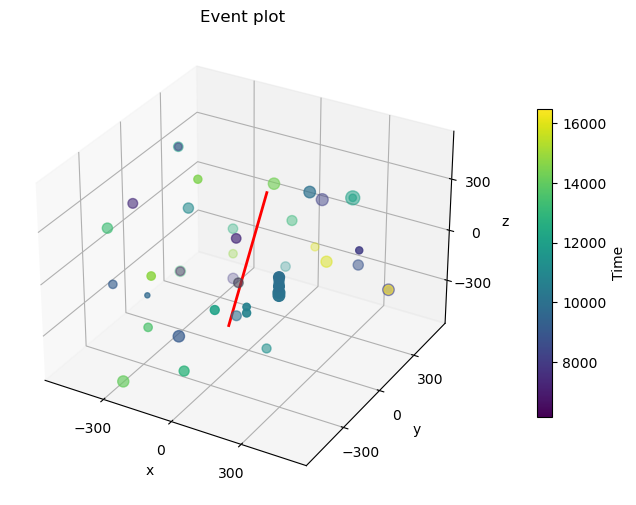

In [37]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event["x"],
    batch_event["y"],
    batch_event["z"],
    s=batch_event["charge"] * 50,
    c=batch_event["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

### 階層的クラスタリング

In [38]:
h_cluster = linkage(batch_event[["time", "x", "y", "z"]])

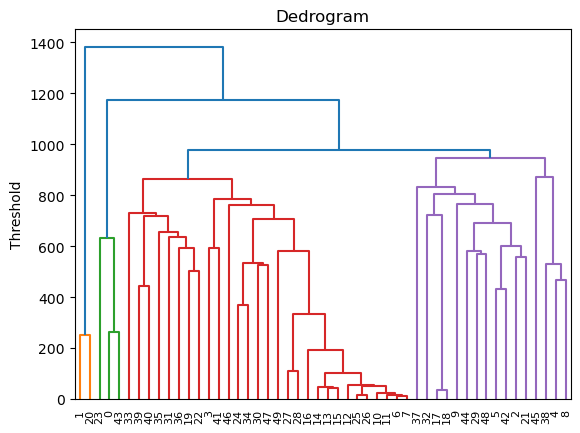

In [39]:
dendrogram(h_cluster)
plt.title("Dedrogram")
plt.ylabel("Threshold")
plt.show()

In [40]:
batch_event.loc[:, "h_labels"] = fcluster(h_cluster, 1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [41]:
batch_event["h_labels"].value_counts().idxmax()

3

In [42]:
batch_event["h_labels"].value_counts()

3     8
16    4
19    4
9     4
5     4
2     3
15    3
7     3
14    3
4     2
1     2
8     2
6     2
13    1
18    1
11    1
10    1
17    1
12    1
Name: h_labels, dtype: int64

In [43]:
# batch_event_ = batch_event[batch_event.duplicated(subset=["h_labels"], keep=False)]
batch_event_ = batch_event[
    batch_event["h_labels"] == batch_event["h_labels"].value_counts().idxmax()
]

In [44]:
batch_event_.shape

(8, 9)

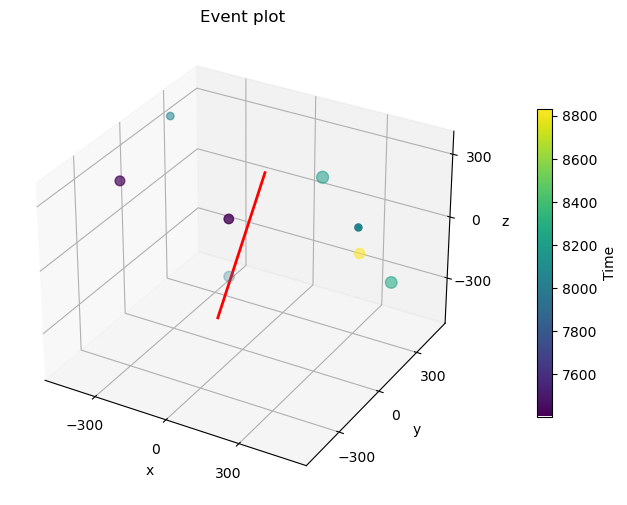

In [45]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(projection="3d")
ax.set_title("Event plot")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xticks([-600, -300, 0.0, 300, 600])
ax.set_yticks([-600, -300, 0.0, 300, 600])
ax.set_zticks([-600, -300, 0.0, 300, 600])

# 散布図を描画
scatter = ax.scatter(
    batch_event_["x"],
    batch_event_["y"],
    batch_event_["z"],
    s=batch_event_["charge"] * 50,
    c=batch_event_["time"],
)

ax.plot3D(
    xs=line_x_details,
    ys=line_y_details,
    zs=line_z_details,
    color=line_color,
    linestyle=line_style,
    linewidth=line_width,
)


cbar = fig.colorbar(scatter, shrink=0.5, pad=0.1)
cbar.set_label("Time")

plt.show()

## Debug

In [230]:
dataset = SQLiteDataset(
    path="dataset/train_440_db.db",
    pulsemaps="pulse_table",
    features=FEATURES.KAGGLE,
    truth=TRUTH.KAGGLE,
    selection=list(event_ids_high_sigma),
    node_truth=None,
    truth_table="meta_table",
    node_truth_table=None,
    string_selection=None,
    loss_weight_table=None,
    loss_weight_column=None,
    index_column="event_id",
)

In [232]:
res = dataset.query_table("meta_table", "event_id")

In [233]:
len(res)

200000

In [234]:
len(event_ids_high_sigma)

148544

In [12]:
dataloader = make_test_dataloader(
    c, selection=list(results[results["sigma"] > 0.5].index)
)

In [13]:
model = load_pretrained_model(c, dataloader)

2023-03-02 07:05:28,447 [INFO] [instantiator] Created a temporary directory at /tmp/tmp6xx7zaih
2023-03-02 07:05:28,448 [INFO] [instantiator] Writing /tmp/tmp6xx7zaih/_remote_module_non_sriptable.py


In [16]:
res = model.predict(
    dataloader=dataloader,
)

2023-03-02 07:07:27,494 [INFO] [cuda] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/jovyan/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/jovyan/.local/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/software/graphnet/src/graphnet/data/dataset.py", line 359, in __getitem__
    sequential_index
  File "/tmp/software/graphnet/src/graphnet/data/dataset.py", line 471, in _query
    )[0]
IndexError: list index out of range


In [17]:
results = pd.read_csv("results.csv")
valid_df = pd.read_csv("valid.csv")
submission_df = pd.read_csv("submission.csv")

In [18]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       200000 non-null  int64  
 1   direction_x      200000 non-null  float64
 2   direction_y      200000 non-null  float64
 3   direction_z      200000 non-null  float64
 4   direction_kappa  200000 non-null  float64
 5   event_id         200000 non-null  float64
 6   zenith           200000 non-null  float64
 7   azimuth          200000 non-null  float64
 8   sigma            200000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 13.7 MB


In [21]:
results.head()

,Unnamed: 0,direction_x,direction_y,direction_z,direction_kappa,event_id,zenith,azimuth,sigma
0,0,-0.072987,0.997028,-0.024660,2.865726,1.432235e+09,1.595459,1.643870,0.590721
1,1,0.655898,0.645177,-0.391846,0.201910,1.432235e+09,1.973434,0.777158,2.225465
2,2,-0.344084,-0.458168,0.819566,0.669028,1.432235e+09,0.610143,4.068248,1.222582
3,3,-0.108527,-0.868880,0.482980,57.414906,1.432235e+09,1.066742,4.588129,0.131974
4,4,-0.281362,0.924257,-0.258039,114.061508,1.432235e+09,1.831788,1.866303,0.093633


In [19]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   event_id  200000 non-null  float64
 1   azimuth   200000 non-null  float64
 2   zenith    200000 non-null  float64
dtypes: float64(3)
memory usage: 4.6 MB


In [20]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   event_id  200000 non-null  float64
 1   azimuth   200000 non-null  float64
 2   zenith    200000 non-null  float64
dtypes: float64(3)
memory usage: 4.6 MB


In [22]:
high_sigma = pd.read_csv("submission_high_sigma.csv")

In [23]:
high_sigma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148544 entries, 0 to 148543
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   event_id  148544 non-null  float64
 1   azimuth   148544 non-null  float64
 2   zenith    148544 non-null  float64
dtypes: float64(3)
memory usage: 3.4 MB
